### Import libraries

In [4]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2

### Limit the amount of GPU ram being used

In [5]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## Remove images that are not good

In [6]:
import check_corrupt_images as checkimages

data_dir = 'data/train'
cci = checkimages.RemoveCorruptImages(data_dir)
cci.remove_images()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

### Load Data

Use tensorflow because it has a dataset API.
It will allow us to build data pipilines to scale on larger datasets

In [17]:
tf.keras.utils.image_dataset_from_directory??

In [7]:
"""
image_dataset does some preproceessing for us:
tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    **kwargs,
)
"""
# Made a folder called data that generates
data = tf.keras.utils.image_dataset_from_directory('data/train')

Found 47630 files belonging to 2 classes.


In [8]:
# Allows use to access our data pipiline
data_iterator = data.as_numpy_iterator()

In [13]:
# Get us a data batch
# We can rerun this line to get a new batch
batch = data_iterator.next()

In [14]:
# Returns us an image and the labels in the form of a tuple
batch[0].shape  # (32, 256, 256, 3) batch size of 32 with a image dim of 256 256 in 3 colours (RGB)

(32, 256, 256, 3)

In [15]:
# The labels of our images where 1 represents
batch[1]

array([1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 1])

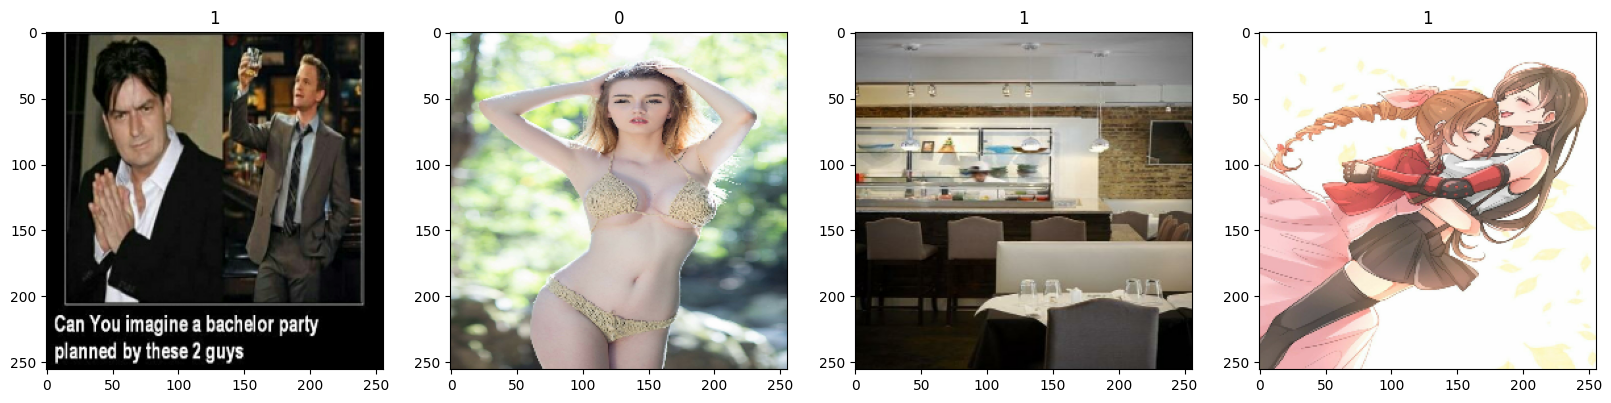

In [16]:

# porn = class 0
# sfw images = class 1
# We can check which labels represents which class:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))  # subplots to plot 10 images at a time
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## Scale the data so that the image values be between 0 and 1. This helps produce quicker results

In [17]:
# Map allows us to transform the data in the pipeline
data = data.map(lambda x, y: (x / 255, y))
# We only divide x by 255 because that is where the rgb colours are located

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [18]:
# Looking at the values now, they are between 0 and 1
data.as_numpy_iterator().next()[0]

array([[[[0.3013174 , 0.15621936, 0.08563112],
         [0.3033701 , 0.16740195, 0.09289216],
         [0.3484375 , 0.18958333, 0.11179534],
         ...,
         [0.850337  , 0.8307292 , 0.8189645 ],
         [0.8509804 , 0.83137256, 0.81960785],
         [0.8509804 , 0.83137256, 0.81960785]],

        [[0.2960478 , 0.15094976, 0.08036152],
         [0.25297183, 0.1314032 , 0.06081495],
         [0.25321692, 0.11783088, 0.05701593],
         ...,
         [0.84705883, 0.827451  , 0.8156863 ],
         [0.8509804 , 0.83137256, 0.81960785],
         [0.8509804 , 0.83137256, 0.81960785]],

        [[0.30588236, 0.16078432, 0.08627451],
         [0.24313726, 0.12941177, 0.06666667],
         [0.23137255, 0.12086397, 0.07239583],
         ...,
         [0.85027575, 0.8306679 , 0.8189032 ],
         [0.8509804 , 0.83137256, 0.81960785],
         [0.8509804 , 0.83137256, 0.81960785]],

        ...,

        [[0.8064338 , 0.6064338 , 0.50055146],
         [0.8214154 , 0.62141544, 0.5155331 ]

### Lets split the training folder into train and evaluation

In [19]:
# We have 1489 batches and each batch has 32 images
len(data)

1489

From the training dataset, we are setting the train size to be 70% and the evaluation size to be 30%

In [20]:
train_size = int(len(data) * .7)
val_size = int(len(data) * .3)  # We are going to evaluate our model as we train
print(train_size)
print(val_size)

1042
446


In [21]:
# take tells us how much data we are going to take from that partition
train = data.take(train_size)  # We are taking 1042 batches * 32 images for our training
# whatever that was used in the train cannot be used in the evaluation partition therefore we skip it
val = data.skip(train_size).take(val_size)  # We are taking 446 batches * 32 images for our evaluation
# Note: our data is being shuffled already by image_dataset_from_directory

## Building the model:


In [22]:
# Sequential API is used for a linear data pipeline
from tensorflow.python.keras.models import Sequential
# These are the layers we will be using
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [23]:
model = Sequential()

In [17]:
MaxPooling2D??

In [24]:
# These are our hyperparameters:
# conv2D : with feature extraction we can expect higher accuracy
# 1st param: make 16 different filters
# 2nd param: kernel size is 3x3
# 3rd param: this will be the stride, going from one pixel to the next
# 4th param: activation function. Any values below 0 will become 0 and anything above will be preserved (helps with non linear patterns)
# 5th param: input_shape 256 pixels x 256 pixels with 3 channels
model.add(
    Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)))  # This is the first layer which is the input
# pooling layer, takes the max value from relu activation and condenses it down to half
""" Default values for MaxPooling2D:
               pool_size=(2, 2),
               strides=None,
               padding='valid',
               data_format=None"""
model.add(MaxPooling2D())

# It is okay to repeat [Conv-Pooling] several times
# we will repeat [Conv-Pooling] two more times to increase learning effect
model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

# Flatten the data down into a single value
model.add(Flatten())

model.add(Dense(256, activation='relu'))  # These are teh fully connected layers (256 neurons)
model.add(
    Dense(1, activation='sigmoid'))  # The final connected layers are between 0 and 1 which represent our class numbers

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 14400)             0

In [26]:
# Using the adam optimizer but there are maybe different ones
# Since we have multiple classes we will use sparse_categorical_crossentropy
# We want to track the accuracy of our model
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

### Train the model

In [29]:
# Creating a log folder
logdir = "logs"

In [30]:
# Useful to save the model at a certain point or for logging
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [35]:

# We will now train the model
# 1 Epoch is run over the entire training set of data
# We then evaluate how well the training is going
hist = model.fit(train, epochs=15, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/15
1042/1042 [==============================] - 392s 376ms/step - loss: 0.0418 - accuracy: 0.9848 - val_loss: 0.2612 - val_accuracy: 0.9333
Epoch 2/15
1042/1042 [==============================] - 388s 372ms/step - loss: 0.0271 - accuracy: 0.9905 - val_loss: 0.2106 - val_accuracy: 0.9437
Epoch 3/15
1026/1042 [============================>.] - ETA: 4s - loss: 0.0288 - accuracy: 0.9906

KeyboardInterrupt: 

### Results

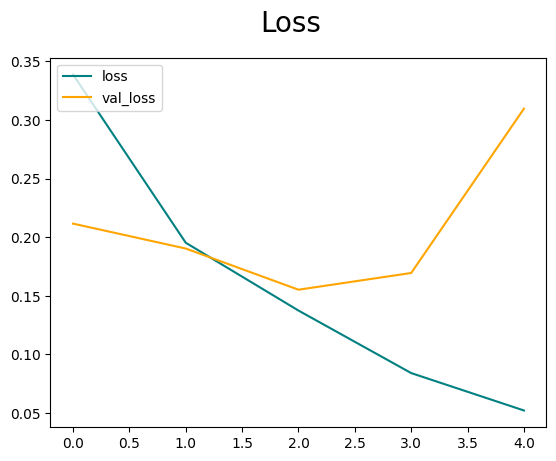

In [32]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

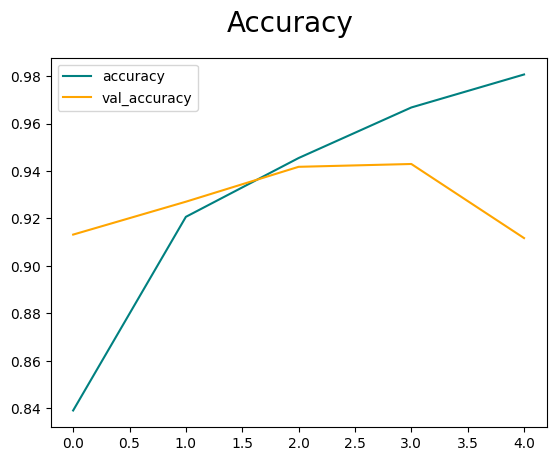

In [33]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### Evaluate

In [34]:
from tensorflow.python.keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [ ]:
print(pre.result(), re.result(), acc.result())

### Test

In [ ]:
img = cv2.imread('154006829.jpg')
plt.imshow(img)
plt.show()

In [ ]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
yhat = model.predict(np.expand_dims(resize/255, 0))